#### Train SAC RL model

The SAC (Soft Actor-Critic) algorithm is an off-policy reinforcement learning method designed for continuous action spaces. It combines the benefits of both policy-based and value-based methods and is known for its sample efficiency and stability.  

The actor in SAC is responsible for selecting actions in the environment. It typically uses a neural network to learn a policy that maps observations to continuous actions.  
SAC uses a stochastic policy, which means it outputs a probability distribution over the available actions, often modeled as a Gaussian distribution.  
This stochasticity helps exploration during training.

Critic: SAC also includes two critics, referred to as Q-networks. These networks estimate the state-action value function, providing two independent value estimates.  
Having multiple critics helps stabilize the training process.

SAC collects data by interacting with the environment. The actor's stochastic policy is used to sample actions,  
and these actions are executed in the environment to collect state-action-reward transitions.
SAC uses an experience replay buffer to store and sample past experiences.  
This buffer allows the algorithm to learn from a diverse set of experiences and reduce sample correlations.

SAC employs a variant of the Bellman equation to update the critics. The key innovation in SAC is the use of a "soft" Bellman backup.   
This involves minimizing a loss that aims to make the critics agree with each other and be close to the minimum of the Bellman error.

The actor's policy is updated based on the soft Q-values from the critics. The objective is to maximize the expected reward, including an entropy term.  
The entropy term encourages exploration by discouraging overly deterministic policies.

SAC introduces a temperature parameter that scales the entropy term in the policy update. This temperature parameter can be learned or adjusted during training.  
It helps balance exploration and exploitation by controlling the level of stochasticity in the policy.

These steps are repeated iteratively, allowing the agent to improve its policy and value functions over time. The process continues until convergence or a specified number of iterations.

SAC's main advantages include:

It can handle continuous action spaces efficiently.
It provides a good balance between exploration and exploitation, thanks to the entropy term.
It benefits from experience replay, which reduces sample correlations and enhances learning stability.
It can be used in combination with target value networks for even more stability.

https://arxiv.org/pdf/1801.01290.pdf

In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard
import os
import sys
from pathlib import Path
from stable_baselines3 import SAC

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")

# # flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym

from src.models.bank_env import BankEnv
from src.visualization import visualize
import src.models.train as train
from src.tests import test_bankmodel_a2c_train as tests
from src.data.definitions import MODEL_PATH, TENSORBOARD_LOGS
from src.models.evaluate import evaluate_policy

Project root: f:\OneDrive\Documents\GitHub\rl-alm


##### First test - just take a random walk in the environment. 

Each episode consists of 60 months. Each timestep interest rates and swap rates are simulated and the bank enters into new mortgages.  
Each month the actor needs to decide on the funding strategy to fund the bank. 

In [4]:
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)


In [5]:
# Random walk in the environment
tests.random_walk(env_id)

2023-10-17 20:54:16.316 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-17 20:54:17.872 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
steps: 60, score: -4415


Define the model. For the initial model we use the A2C model. 

In [8]:
env = gym.make(env_id, render_mode="human")

# Define a Lineair Learning Rate Scheduler
def linear_schedule(initial_value: float):
    """Linear learning rate schedule."""

    def func(progress_remaining: float) -> float:
        """Progress will decrease from 1 (beginning) to 0."""
        return progress_remaining * initial_value

    return func

initial_lr = 0.001
n_steps = 60
model_name = 'SAC'
ent_coef= 0.001
# policy_kwargs = dict(
#    net_arch=[128, 128]
# )


model = SAC(
        "MultiInputPolicy",        
        env,        
        tensorboard_log=TENSORBOARD_LOGS,
        verbose=2,        
        learning_rate=linear_schedule(initial_lr),
        ent_coef='auto',
        use_sde = True, # Use generalized State Dependent Exploration (gSDE) instead of action noise exploration
        # policy_kwargs = policy_kwargs,        
    )

2023-10-17 20:56:29.891 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-17 20:56:31.308 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


##### Train the model in the environment and save it

Logging to f:\OneDrive\Documents\GitHub\rl-alm\tensorboard_logs_1


f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reset_episode_statistics to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reset_episode_statistics` for environment variables or `env.get_wrapper_attr('reset_episode_statistics')` that will search the reminding wrappers.
  logger.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 60        |
|    ep_rew_mean     | -5.54e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 31        |
|    time_elapsed    | 7         |
|    total_timesteps | 240       |
| train/             |           |
|    actor_loss      | 69.6      |
|    critic_loss     | 1.64e+04  |
|    ent_coef        | 1.01      |
|    ent_coef_loss   | 0.0114    |
|    learning_rate   | 0.000203  |
|    n_updates       | 139       |
|    std             | 0.0499    |
----------------------------------


f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.episode_rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_rewards` for environment variables or `env.get_wrapper_attr('episode_rewards')` that will search the reminding wrappers.
  logger.warn(


Model name: SAC, Steps: 300, Mean: -7555.8, IQR: 7001.0, CVaR: -15635.0


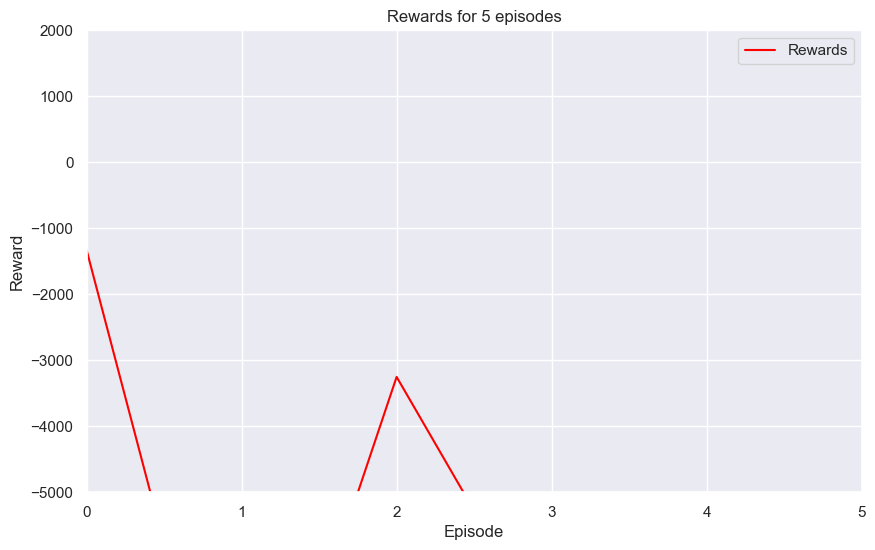

In [9]:
steps = 300
 
model, mean, episode_iqr, episode_cvar, episode_rewards = train.train( model, env, total_timesteps=steps, conf_level=0.95, tb_log_name= TENSORBOARD_LOGS)
modelpath = Path(    
        MODEL_PATH,
        model_name + "_" + str(steps) + ".zip",
    )
model.save(modelpath)
print(f"Model name: {model_name}, Steps: {steps}, Mean: {mean}, IQR: {episode_iqr}, CVaR: {episode_cvar}")
visualize.plot_rewards(episode_rewards, interpolate_line=False, ylim=(-5000,2000))

In [8]:
print(model.policy)

MultiInputPolicy(
  (actor): Actor(
    (features_extractor): CombinedExtractor(
      (extractors): ModuleDict(
        (liquidity): Flatten(start_dim=1, end_dim=-1)
        (cashflows): Flatten(start_dim=1, end_dim=-1)
        (swap_rates): Flatten(start_dim=1, end_dim=-1)
        (bank_rates): Flatten(start_dim=1, end_dim=-1)
        (features): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=52, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=4, bias=True)
    (log_std): Linear(in_features=256, out_features=4, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): CombinedExtractor(
      (extractors): ModuleDict(
        (liquidity): Flatten(start_dim=1, end_dim=-1)
        (cashflows): Flatten(start_dim=1, end_dim=-1)
        (swap_rates): Flatten(start_dim=1, end_dim=-1)
   

In [9]:
def show_model(env, model) -> int:
    """Show the model in the environment"""        
    # env.set_render_output(modelpath.stem)
    obs, info = env.reset()
    score = 0
    terminated = False
    truncated = False
    # env.set_render_output('A2C')

    while not terminated and not truncated:
        action, _state = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        score = score + reward
        # env.render()
        df = env.list_model()    
    env.plot()
    env.close()    
    return score, df

score, df = show_model(env, model)
print ('final score: ', score)
df.head(60)

f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.list_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.list_model` for environment variables or `env.get_wrapper_attr('list_model')` that will search the reminding wrappers.
  logger.warn(
f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.list_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.list_model` for environment variables or `env.get_wrapper_attr('list_model')` that will search the reminding wrappers.
  logger.warn(
f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.list_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.lis

TypeError: 'NoneType' object is not subscriptable

In [10]:
mean_reward, irq, es, rewards = evaluate_policy(model, env, n_eval_episodes=500)

In [11]:
print(f"number of episodes = {len(rewards)}, mean_reward={mean_reward:.2f} Expected Shortfall={es:.2f} Interquartile Range={irq:.2f}")

number of episodes = 500, mean_reward=-0.16 Expected Shortfall=-20.50 Interquartile Range=0.00


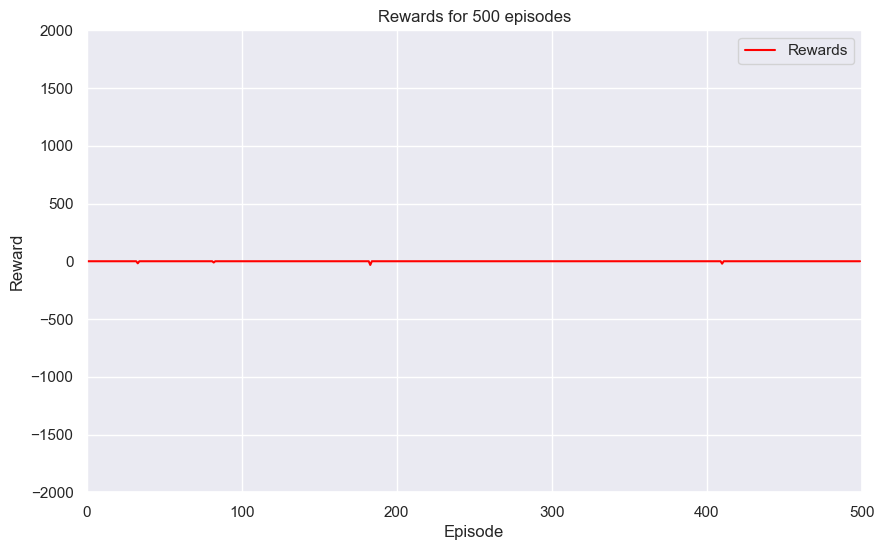

In [12]:
visualize.plot_rewards(rewards, interpolate_line=False)